In [1]:
%pip install gensim

In [2]:
%pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import gensim.downloader as api

In [2]:
api.info("word2vec-google-news-300")

{'num_records': 3000000,
 'file_size': 1743563840,
 'base_dataset': 'Google News (about 100 billion words)',
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/word2vec-google-news-300/__init__.py',
 'license': 'not found',
 'parameters': {'dimension': 300},
 'description': "Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).",
 'read_more': ['https://code.google.com/archive/p/word2vec/',
  'https://arxiv.org/abs/1301.3781',
  'https://arxiv.org/abs/1310.4546',
  'https://www.microsoft.com/en-us/research/publication/linguistic-regularities-in-continuous-space-word-representations/?from=http%3A%2F%2Fresearch.microsoft.com%2Fpubs%2F189726%2Frvec

In [4]:

import xgboost as xgb
import numpy as np
import spacy
import pandas as pd
import plotly.graph_objects as go
import re
import string
from sklearn.model_selection import train_test_split


In [5]:
wv = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [3]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 955.7 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
nlp = spacy.load('en_core_web_lg')

In [8]:
def preprocess_and_vectorize(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    if not filtered_tokens:
        return np.zeros(300)
    return wv.get_mean_vector(filtered_tokens)

In [9]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\f', '', text)
    return text

In [10]:
df = pd.read_csv("../SMSSpamCollection.csv")

In [11]:
df['target'].value_counts()

target
ham     4827
spam     747
Name: count, dtype: int64

In [12]:
df['message_clean'] = df['message'].apply(lambda x: clean_text(x))

In [13]:
df['vector'] = df['message_clean'].apply(lambda x: preprocess_and_vectorize(x))

In [14]:
df['target_encoded'] = df['target'].map(
    {
        'ham': 0,
        'spam': 1
    }
)

In [15]:
x = df['vector'].values
y = df['target_encoded']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2 ,random_state=42, stratify=df.target_encoded)

In [17]:
x_train_2d = np.stack(x_train)
x_test_2d = np.stack(x_test)

In [18]:
model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
    )

In [19]:
model.fit(x_train_2d, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics

def conf_matrix(confusion_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix)
    disp.plot()

Train:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3861
           1       1.00      0.99      1.00       598

    accuracy                           1.00      4459
   macro avg       1.00      1.00      1.00      4459
weighted avg       1.00      1.00      1.00      4459

Test:               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



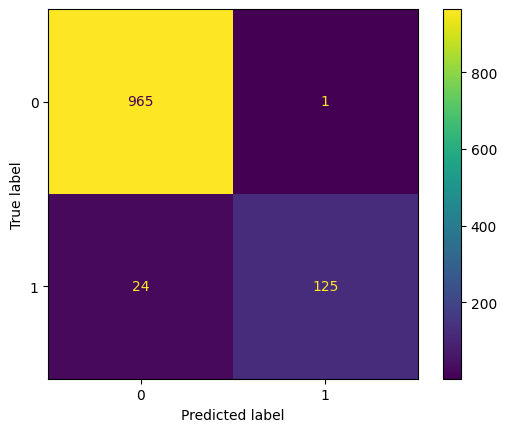

In [21]:
y_pred_class = model.predict(x_test_2d)
y_pred_train = model.predict(x_train_2d)

print('Train: {}'.format(classification_report(y_train, y_pred_train)))
print('Test: {}'.format(classification_report(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

## Test predict

In [20]:
%pip install pytesseract
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [21]:
import pytesseract
import shutil
import os
import random
try:
    from PIL import Image
except ImportError:
    import Image

In [22]:
from google.colab import files

uploaded = files.upload()

Saving SMS_spam1.png to SMS_spam1.png


In [23]:
file_name = next(iter(uploaded))
file_name

'SMS_spam1.png'

In [24]:
lang = 'eng'
config = r'--oem 3 --psm 1'
extractedInformation = pytesseract.image_to_string(Image.open('/content/' + file_name), lang = lang, config = config)
print(extractedInformation)

Your IRS tax refund is
pending acceptance.
Must accept within 24

hours: http://bit.ly/
sdfsdf.



In [25]:
e = extractedInformation

In [55]:
clean_text(e)

'your irs tax refund is pending acceptance must accept within hours sdfsdf '

In [ ]:
e_vector = preprocess_and_vectorize(e)
e_vector

In [67]:
e_vector_2d = e_vector.reshape(1, -1)

In [70]:
model.predict(e_vector)

array([0])

## Save model

In [22]:
import pickle
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [23]:
# Load the model from the file
with open("xgboost_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)


In [64]:
predictions = loaded_model.predict(e_vector_2d)
predictions

array([0])

## Preprocess to pass

In [68]:
def preprocess_and_vectorize(text):
    # clear text
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\f', '', text)
    #vectorize
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    if not filtered_tokens:
        return np.zeros(300)
    return wv.get_mean_vector(filtered_tokens).reshape(1, -1)
